### Things to think about:

- sampleid = 'db1300602D20161030' doesn't work for some reason. It seems to fail when looking at smoothing extents at different frequencies

In [1]:
# only used for the Jupyter Notebook version:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#display(HTML("<style>.container { width:60% !important; }</style>"))
#display(HTML("<style>.container { width:42% !important; }</style>"))
# max line length (79)
###############################################################################
# max comments/doc strings line length (72)
########################################################################

import spectrum
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sg
from scipy.stats import chi2
from scipy.special import digamma
import xarray as xr

# ignoring warnings for a couple of specific future code changes
import warnings

#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Define the paths to the data

In [2]:
outdir = 'C:/Users/HoldenJe/Drift/jupyter_notebooks/rotary_spectra/output/'
jupyterdir = 'C:/Users/HoldenJe/Drift/jupyter_notebooks/'
    
projdir = os.path.join(jupyterdir, 'rotary_spectra/input/nancys_sample_data/')
projdir_reduced = os.path.join(jupyterdir, 'rotary_spectra/input/nancys_sample_data/reduced/')

ciopse = os.path.join(projdir, 'ciopse_bc12_plus/output_per_drifter')
ciopse_filter = os.path.join(projdir, ('ciopse_bc12_plus_filter_30x30/output_per_drifter/'))
#datadir = os.path.join(projdir, ('CIOPSEBC12PLUS-CIOPSEBC12PLUSFILTER30/'))

ciopse_files = glob.glob(os.path.join(ciopse,'*.nc'))
ciopse_files.sort()

ciopse_files_filter = glob.glob(os.path.join(ciopse_filter,'*.nc'))
ciopse_files_filter.sort()

label_map = {'CIOPSEBC12PLUS': 'CIOPSE',
             'CIOPSEBC12PLUSFILTER30': 'CIOPSE-filter75km'}

In [140]:
#define functions to return the Coriolis and tidal frequencies
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
    lat : str
        Latitude in degrees
        
    Returns
    -------
    The Coriolis frequecy at latitude lat
    """    
    omega = 7.2921159e-5;
    return 2 * np.sin(lat * 2 * np.pi / 360) * omega * (3600) * 24;


#define functions to return the Coriolis and tidal frequencies
def corfreq_range(d, lats=['mean', 'min', 'max']):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
    d : xr.DataSet
        dataset containing latitude values
    lats : list
        list of strings defining which frequencies will be 
        returned in the array
        
    Returns
    -------
    An np array containg Coriolis frequecy at chosen latitudes
    """    
    
    freqdict = {'mean': corfreq(d.lat.values.mean()) / 2 / np.pi, 
                'min': corfreq(d.lat.values.min()) / 2 / np.pi, 
                'max':corfreq(d.lat.values.max()) / 2 / np.pi}
    
    return np.array([freqdict[l] for l in lats])


def tidefreq():
    """ Returns an array of eight major tidal frequencies in rad / day.  
    See Gill (1982) page 335. 
    
    is 327.85 referring to 'Q1'?

    """   
    
    tidedict = {
        'M2': {'freq': 12.4206, 'type': 'semidiurnal', 'label': 'principal lunar'}, 
        'S2': {'freq': 12.0000, 'type': 'semidiurnal', 'label': 'principal solar'}, 
        'N2': {'freq': 12.6584, 'type': 'semidiurnal', 'label': 'larger lunar elliptic'}, 
        'K2': {'freq': 11.9673, 'type': 'semidiurnal', 'label': 'luni-solar semidiurnal'},
        'K1': {'freq': 23.9344, 'type': 'diurnal', 'label': 'luni-solar diurnal'}, 
        'O1': {'freq': 25.8194, 'type': 'diurnal', 'label': 'principal lunar diurnal'}, 
        'P1': {'freq': 24.0659, 'type': 'diurnal', 'label': 'principal solar diurnal'}, 
        'Q1': {'freq': 26.86836, 'type': 'diurnal', 'label': 'larger lunar elliptic', 'freq_alt': 327.85}, 
    }

    #is 327.85 referring to 'Q1'?
    tide_const = [tidedict[t]['freq'] for t in tidedict.keys()]
    returndict = {'tide_freqs': 24 * 2 * np.pi / np.array(tide_const),
                  'tide_dict': tidedict}
    
    return returndict
    

def mconf(K, gamma, str):
    """ Compute symmetric confidence intervals for multitaper 
    spectral estimation.
    
    Parameters
    ----------
    K : float 
        Number of tapers used in the spectral estimate, normally 2*P-1
    gamma : float 
        confidence level, e.g., 0.95
    str : str
        'lin' to return confidence intervals for linear axis 
        'log' to return confidence intervals for log10 axis 
    
    Returns
    -------
    ra, rb:  Ratio factors for confidence interval
        
    If S0 is the true value of the spectrum and S is the spectral estimate,
    then the confindence interval is defined such that 
    
        Probability that ra < S/S0 < ra = gamma     (linear case)
        Probability that ra < log10(S)/log10(S0) < ra = gamma (log10 case)

    The confidence interval will be S*ra to S*rb for the spectral values
    in linear space, or S*10^ra to S*10^rb in log10 space.  If log10(S) 
    is plotted rather than S with a logarithmic axis, the latter would 
    become log10(S) + ra to log10(S) * rb.    
    """

    dx=0.0001
    
    # Compute pdf symmetrically about unity
    if str=='lin':
    
        # from one to minus one
        x1 = np.arange(1 - dx / 2, -1, step=-dx) * 2 * K
        # from 1 to three
        x2 = np.arange(1 + dx / 2, 3 ,step=dx) * 2 * K  
        fx = (chi2.pdf(x1, 2 * K) + chi2.pdf(x2, 2 * K)) * 2 * K
        sumfx = np.cumsum(fx) * dx

        ii = np.where(sumfx >= gamma)[0][0]
        ra = x1[ii] / 2 / K
        rb = x1[ii] / 2 / K
    
    elif str == 'log':
        
        xo = np.log(2) + np.log(1 / 2 / K) + digamma(K) #see pav15-arxiv
        c = np.log(10)
        xo = xo / c  #change of base rule
    
        x1 = np.power(10, np.arange(xo - dx / 2, xo - 2, step=-dx))   
        x2 = np.power(10, np.arange(xo + dx / 2, xo + 2, step = dx))  
    
        fx1 = c * 2 * K * np.multiply(x1, chi2.pdf(2 * K * x1, 2 * K))
        fx2 = c * 2 * K * np.multiply(x2, chi2.pdf(2 * K * x2, 2 * K))

        sumfx = np.cumsum(fx1 + fx2) * dx
    
        ii = np.where(sumfx >= gamma)[0][0]
        ra = np.log10(x1[ii])
        rb = np.log10(x2[ii])
    
    return ra, rb    


def concat_outputs(dconcat, buoyid=None):
    """ """
    setnames = [d.setname.values[0] for d in dconcat]
    dcombine = xr.concat(dconcat, pd.Index(setnames, name='setname'))
    dcombine.dropna(dim='time')
    return dcombine    


def process_datasets(files):
    """ """
    datadict = {}
    for f in files:
        d = xr.open_dataset(f)
        if 'setname' not in list(d.dims.keys()):
            sname = [d.setname if 'setname' in d.keys() 
                     else d.ocean_model_name][0]
            d = d.assign_coords(setname=sname)
            d = d.expand_dims('setname')

        buoydict = {'buoyid': d.obs_buoyid,
                    'ds': d, 
                    'filename': f,
                    'setname': d.setname.values[0]}
        datadict[d.obs_buoyid] = buoydict
        
    return datadict


def create_cvdict(d):
    """ """
    # build complex velocities
    cv_obs = (d.isel(setname=0).ueast_drifter.values 
              + 1j * d.isel(setname=0).vnorth_drifter.values)
    cvdict = {'Observations': cv_obs}
    setnames = list(d.setname.values)
    
    for sind in range(0, len(setnames)):
        dsel = d.isel(setname=sind)
        cvdict[str(setnames[sind])] = \
            dsel.ueast_ocean.values + 1j * dsel.vnorth_ocean.values
    return cvdict


def add_reference_lines(
    ax, d, 
    tidal=True, 
    coriolis=True, 
    cori_lats=['mean', 'min', 'max']
):
    """ helper function that plots reference lines for the main
    tidal frequencies as well as for the coriolis frequency"""
    if tidal:
        # add reference lines for major tidal frequencies        
        tidedict = tidefreq()
        tcount = 0
        for tidal_freq in tidedict['tide_freqs'] / 2 / np.pi:  
            tlab = 'Tidal Frequencies'
            if tcount > 0:
                tlab = '__nolabel'
            tcount += 1
            ax.axvline(tidal_freq, 
                       linestyle="--", 
                       color="gray",
                       linewidth=1,
                       label=tlab)

    if coriolis:
        # add reference lines for the Coriolas freq 
        # at min, max, and mean latitudes
        ccount = 0
        for coriolis_freq in corfreq_range(d, cori_lats):
            clab = 'Coriolis Frequency at\nmean latitude'
            if ccount > 0:
                clab = '__nolabel'
            ccount += 1
            ax.axvline(coriolis_freq,
                       color="black",
                       linewidth=1,
                       label=clab)


def calc_rotary_spectrum(cv, dt, P=4):
    """Calculate rotary spectrum using mulit taper method with P tapers
    http://www.jmlilly.net/course/labs/html/SpectralAnalysis-Python.html"""

    psi, eigs = spectrum.mtm.dpss(np.size(cv), NW=P, k=2 * P - 1)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f, _ = sg.periodogram(cv - np.mean(cv), fs=1 / dt)

    Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv - np.mean(cv), 
                                                 k=2 * P - 1,  
                                                 NFFT=np.size(cv), 
                                                 v=psi, 
                                                 e=eigs, 
                                                 method="unity")

    S = np.mean(np.transpose(np.abs(Zk) ** 2), axis=1) * dt
        
    #to compute adaptive version just FYI
    #Zk, weights, eigenvalues = spectrum.mtm.pmtm(cv-np.mean(cv), k=2*P-1, 
    #    NFFT=np.size(cv), v=psi, e=eigs, method="adapt")
    #S=np.mean(np.transpose(np.abs(Zk)**2) * weights, axis=1) * dt

    return f, S


def add_smoothing_lines(ax, f, P, color='orange'):
    """ show smoothing extents at different frequencies """
    io=(1, 50, 200, 800)
    yo=(10 ** -2, 10 ** -3, 10 ** 0, 10 ** -5)
    plt.sca(ax)
    for i in range(np.size(io)):
        if i==0:
            plt.hlines(yo[i], 
                       f[io[i]], 
                       f[io[i] + P], 
                       linewidth=3, 
                       color=color, 
                       label='smoothing extent (P=' + str(P) + ')')
        else:
            plt.hlines(yo[i], 
                       f[io[i] - P], 
                       f[io[i] + P], 
                       linewidth=3, 
                       color=color, 
                       label='__nolabel')
           
        
def plot_freq(
    ax, f, S, 
    c=None, 
    label='__nolabel', 
    xlab=None, 
    ylab=None, 
    r=None, 
    cis=False, 
    filled=True, 
    P=None
):
    """ Plot the positive and negative frequencies """
        
    # plot the frequencies
    rs = ax.loglog(f, S, color=c, label=label, zorder=100)

    # if plotting the confidence intervals
    if cis:
        # be sure to use the same color as the main line
        c = rs[0].get_color()
        cis_lab = ['__nolabel', ('95% confidence interval (' + str(label) + ')')]

        # if using a filled range, set the cis line labels to None and
        # label the filled range instead
        if filled:
            filled_lab = ('95% confidence interval (' + str(label) + ')')
            cis_lab = ['__nolabel', '__nolabel']
            fill_kwargs = {'color': c, 'label': filled_lab, 'alpha': 0.1, 'zorder': -10}
            ax.fill_between(f, (10 ** r[0]) * S, (10 ** r[1]) * S, **fill_kwargs)

        # plot lines for the confidence intervals as well
        for ci, lab in zip([r[0], r[1]], cis_lab):
            ci_lines_kwargs = {'color': c, 'linewidth': 0.75, 
                               'linestyle': '-', 'label': 
                               lab, 'zorder': -5}
            ax.loglog(f, (10 ** ci) * S, **ci_lines_kwargs)

    # give the axis some labels
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)


def plot_rotary_spectrum(f, S, axs, 
                                label='__nolabel', 
                                color=None, 
                                P=None, 
                                smoothing_lines=False, 
                                confidence_intervals=False, 
                                filled=False):
    """Plot the rotary sepctrum with positve frequencies 
    on the right hand axis and negative frequencies on the left"""
    
    if len(axs) == 1:
        axs = [axs[0], axs[0]]
        
    if len(axs) > 2:
        print('The number of ax in the axs list must be either 1 or 2. '
              + 'Unable to create plot.')
    
    ci_range = None
    if P:
        ci_range = mconf(2 * P - 1, 0.95, 'log')
    
    plot_freq(axs[1], 
              -f[np.where(f < 0)], 
              S[np.where(f < 0)],  
              c=color,
              label=label,
              xlab='Negative Frequency (cycles/day)', 
              ylab='Power Spectral Density (m$^2$/s$^2$ days)', 
              r=ci_range, 
              cis=confidence_intervals, 
              filled=filled,
              P=P)

    plot_freq(axs[0], 
              f[np.where(f > 0)], 
              S[np.where(f > 0)], 
              c=color,
              label=label,
              xlab='Positive Frequency (cycles/day)', 
              r=ci_range, 
              cis=confidence_intervals, 
              filled=filled,
              P=P)

In [141]:
def plot_rotary_spectral_estimate(d, outdir, P=4):
    d = d.dropna(dim='time')
    dt = (d.time[1] - d.time[0]).values / np.timedelta64(1,'D')
    cvdict = create_cvdict(d)
    names = list(cvdict.keys())
    cvs = [cvdict[n] for n in names]
    colors = ['black'] + [None] * (len(names)-1)
    #colors = [None] * (len(names))
    
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6), dpi=300)
    for setname, cv, col in zip(names, cvs, colors):
        
        f, S = calc_rotary_spectrum(cv, dt, P=4)
        plot_rotary_spectrum(
            f, S, 
            [ax[1], ax[0]], 
            label=setname, 
            color=col, 
            P=P, 
            smoothing_lines=True, 
            confidence_intervals=True,
            filled=True
        )

    for n in range(np.size(ax)):
        ax[n].autoscale(enable=True, tight=True, axis='x') 
        add_reference_lines(ax[n], d, cori_lats=['mean'])
        ax[n].grid(linestyle=':')
        add_smoothing_lines(ax[n], f, P)
        
    handles, labels = ax[0].get_legend_handles_labels()
    lgd = fig.legend(handles,
               labels,
               loc='center left', 
               bbox_to_anchor=(1, 0.5), 
               frameon=False)
               #title=(str(d.obs_buoyid) + '\n'))
               #title=(str(d.obs_buoyid) + ' (P=' + str(P) + ')' + '\n'))
    
    ax[0].invert_xaxis()
    fig.tight_layout(h_pad=2, w_pad=2)
    stitle = fig.suptitle('Multitaper Rotary Spectral Estimate\n' + str(d.obs_buoyid), y=1.05)  # , y=1.01);
    plt.savefig(
        os.path.join(outdir, 
                     ('multitaper_with_conf_' + str(d.obs_buoyid) + '_' + str(P) + '.png')),
        bbox_extra_artists=(lgd, stitle), 
        bbox_inches='tight',
        dpi=300
    )

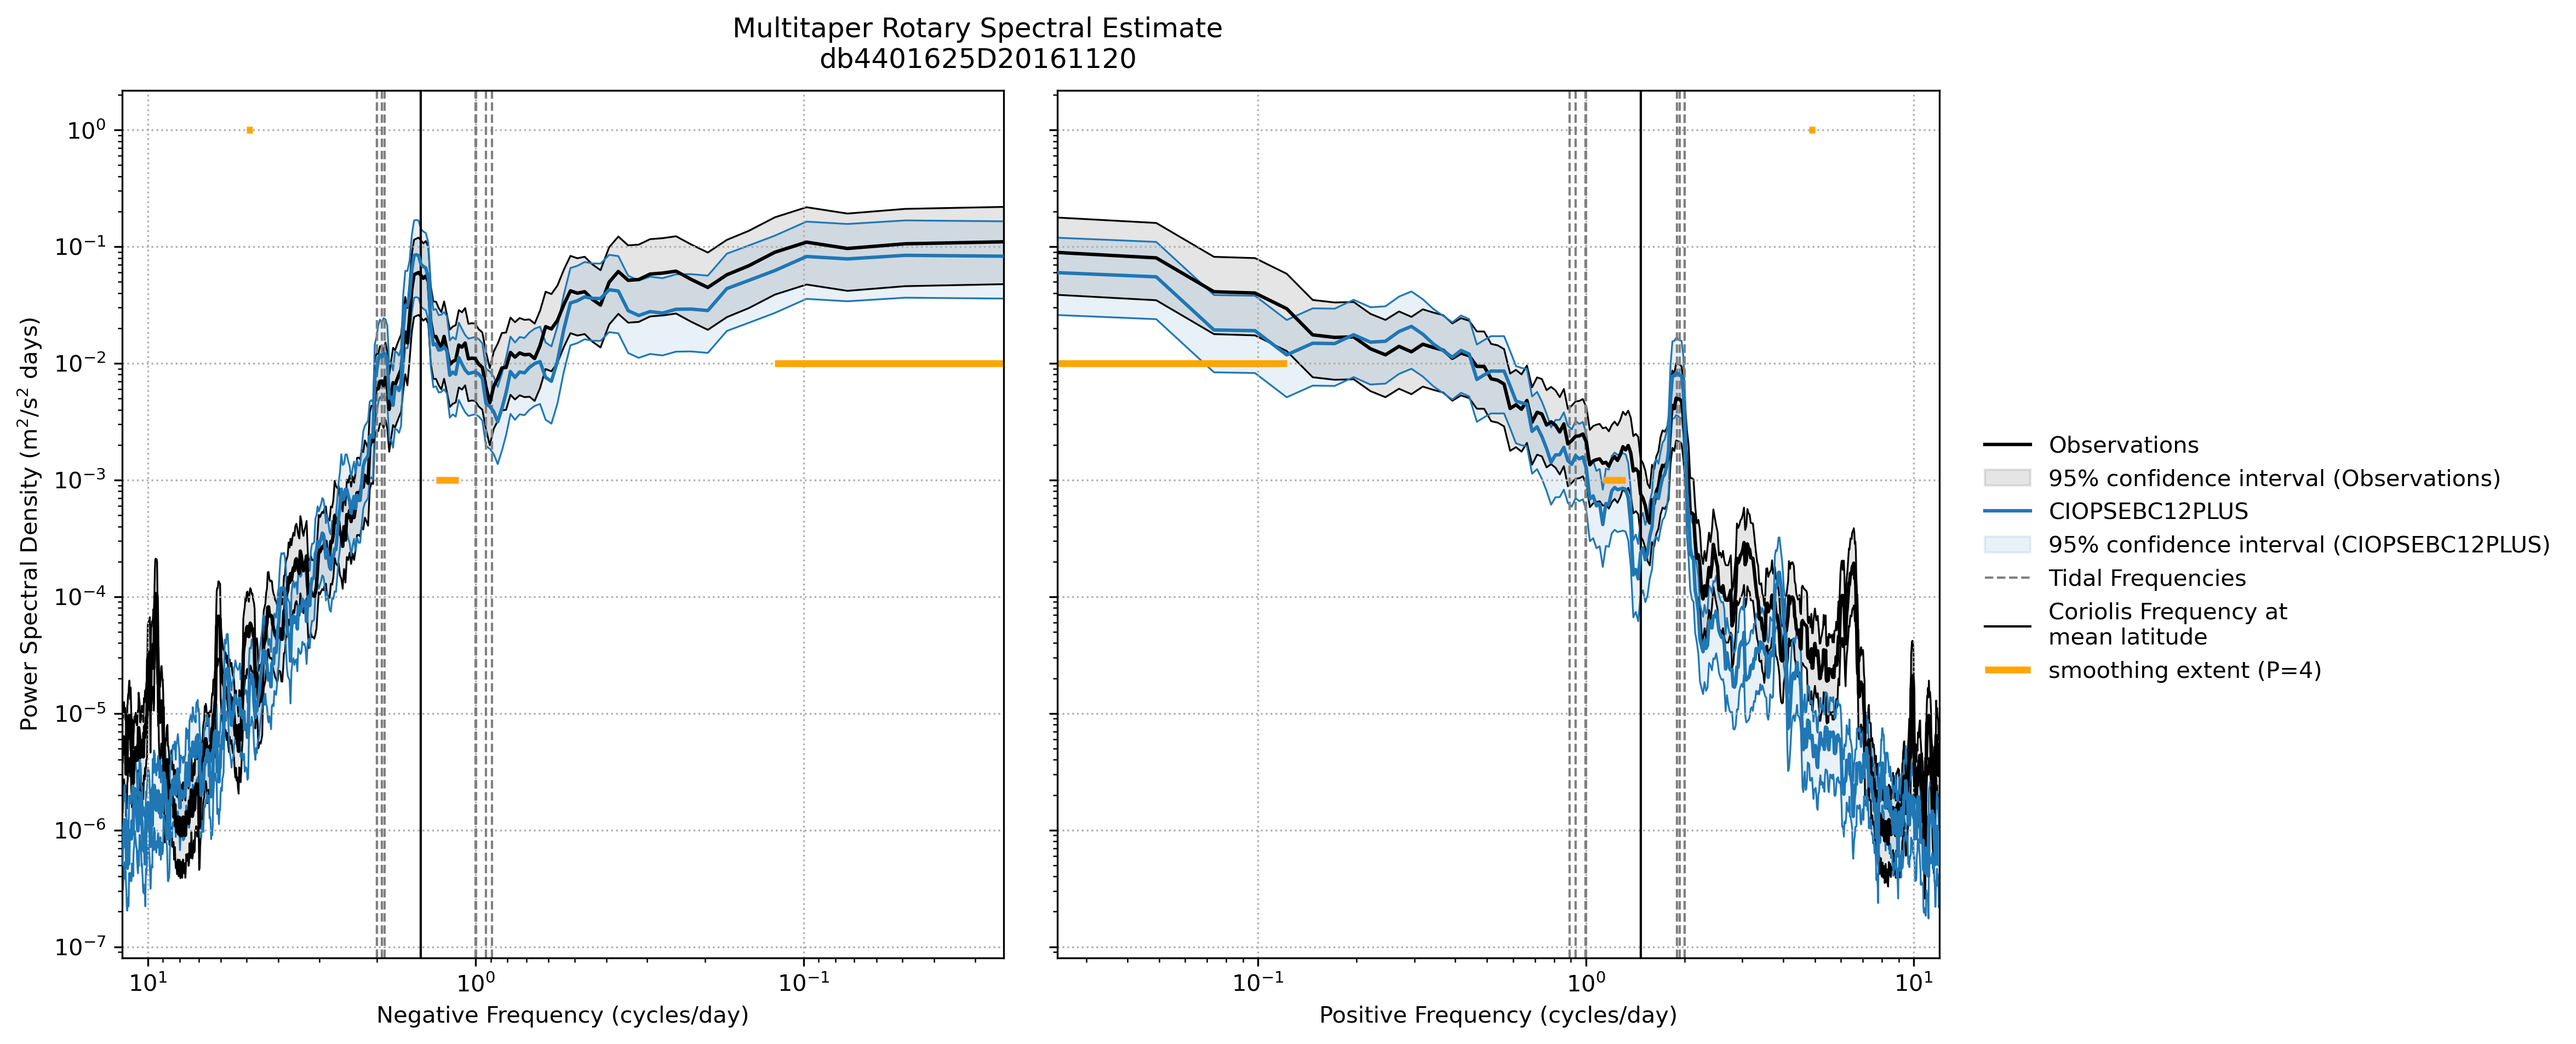

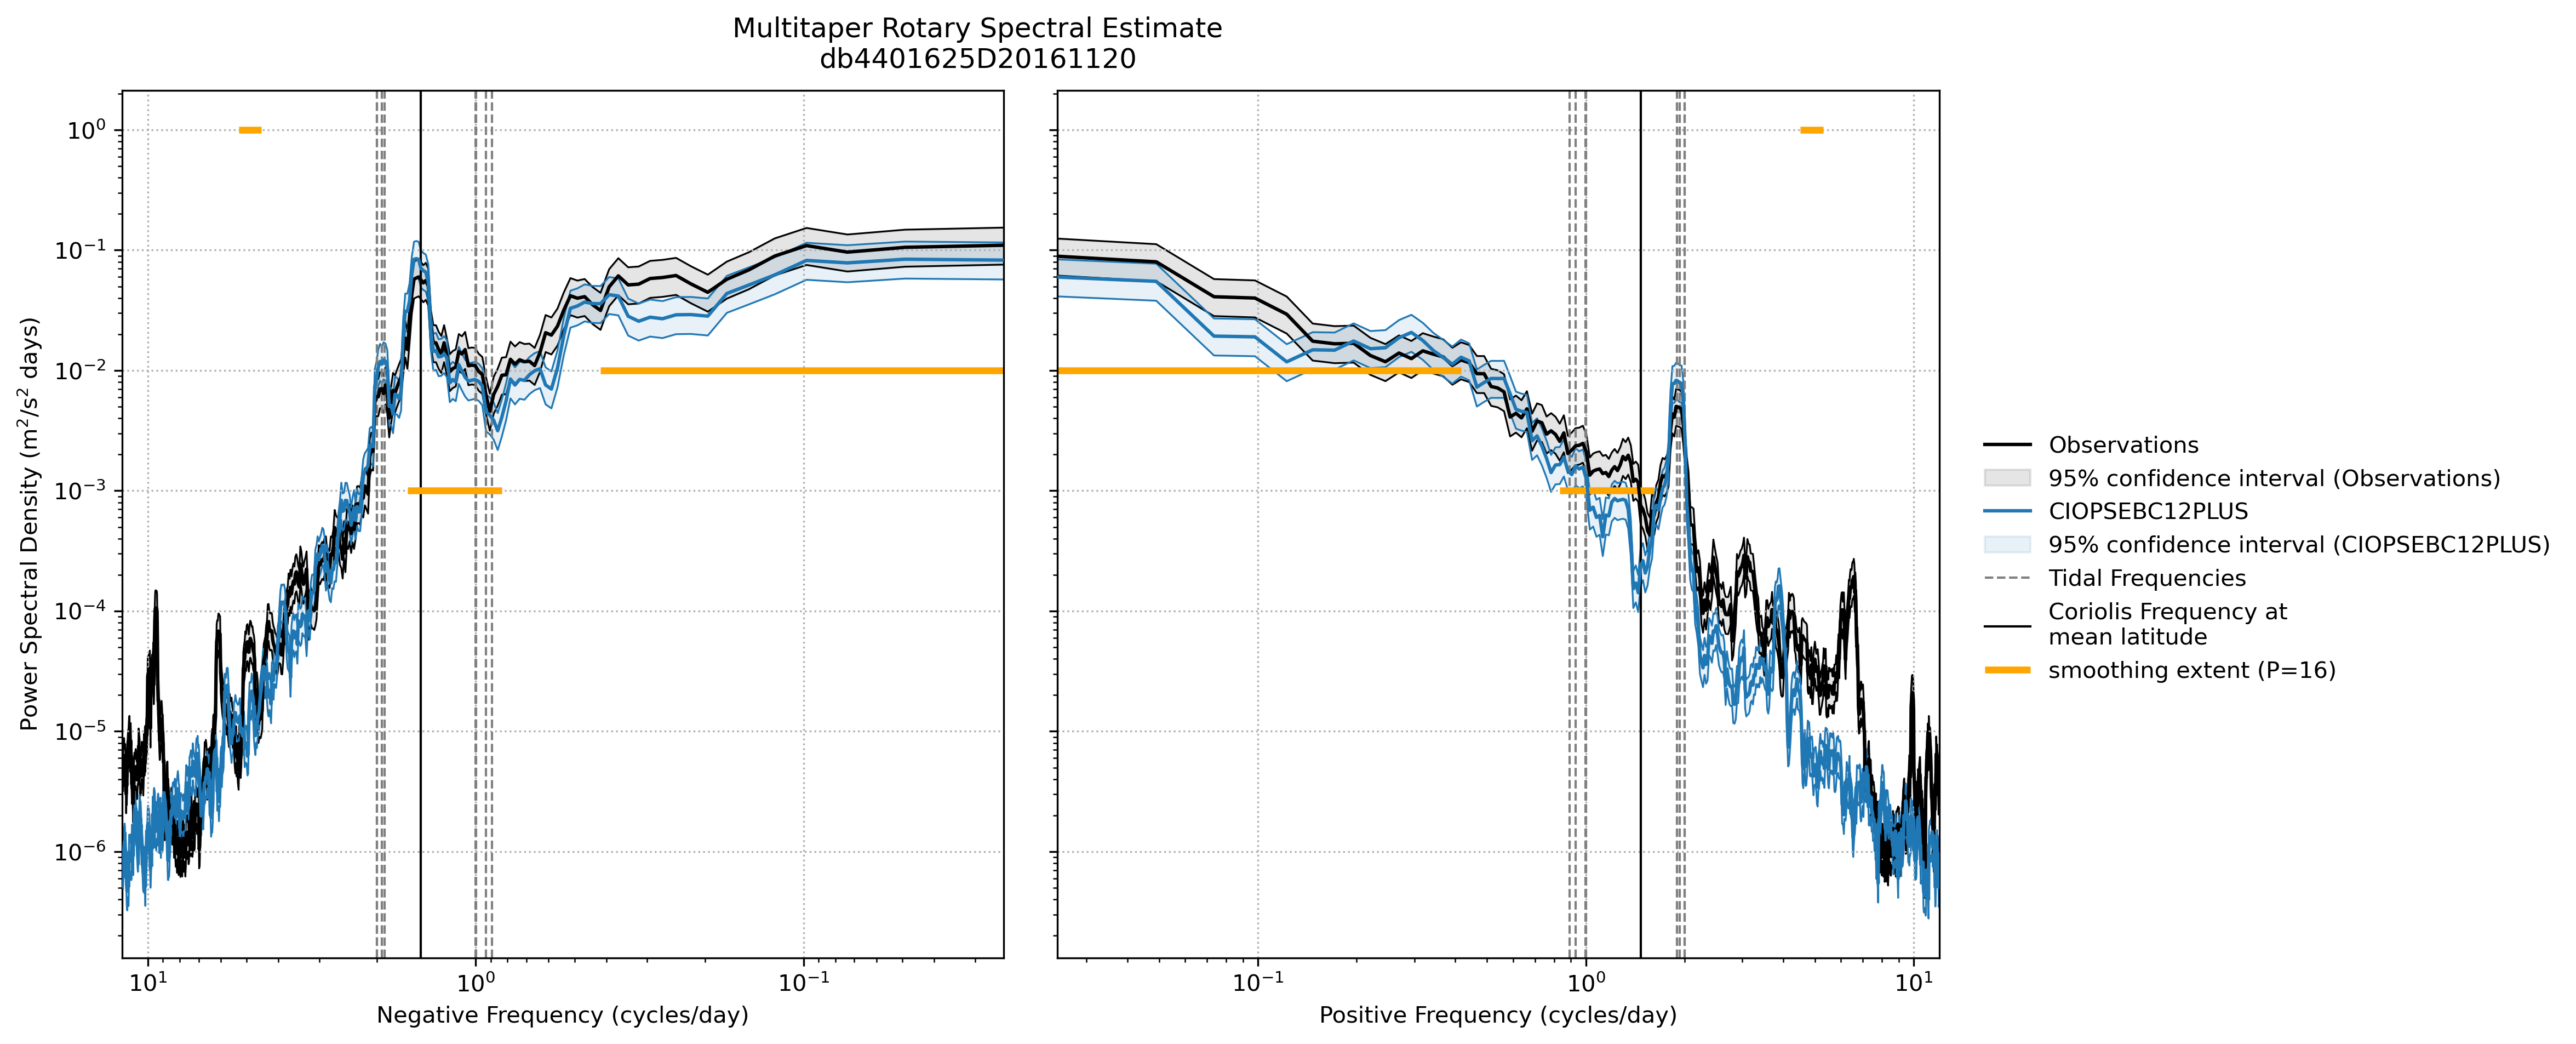

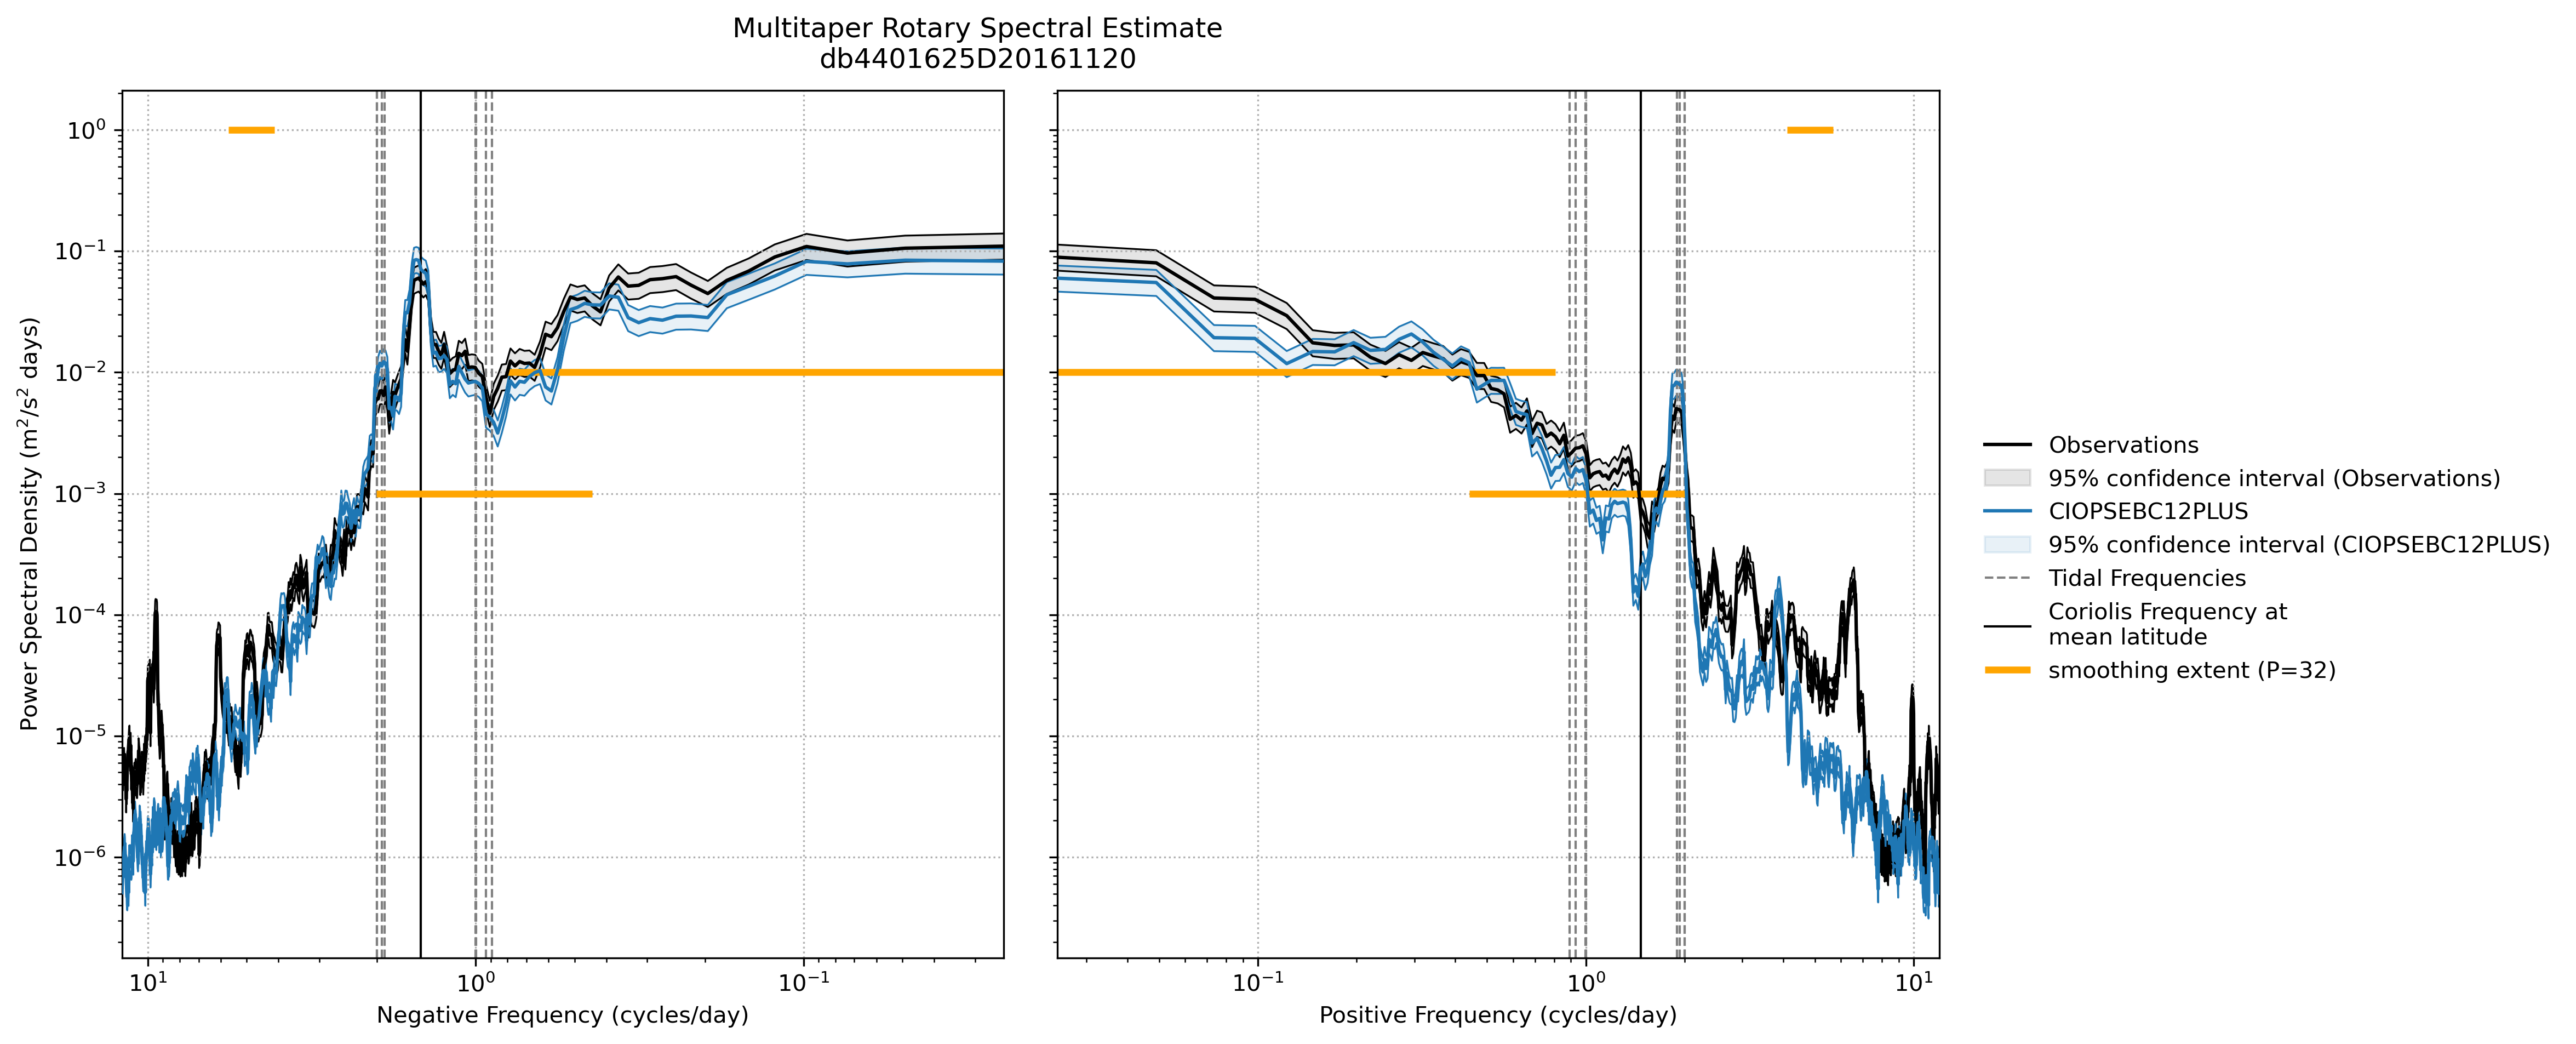

In [142]:
############################################################################
# Example with multiple datasets:
############################################################################
sampleid = 'db4401625D20161120'
datadict = process_datasets(ciopse_files)
datadict_filtered = process_datasets(ciopse_files_filter)
buoyids = datadict.keys()

for buoyid in buoyids:
    
    if sampleid not in buoyid:
        continue
    
    for p in [4, 16, 32]:
        plot_rotary_spectral_estimate(datadict[buoyid]['ds'], outdir, P=p)
    
    #plot_rotary_spectral_estimate(datadict[buoyid]['ds'], outdir, P=4)